### This notebook uses a breathing actuation sequence that computes triggers inflation deflation based upon an average inhale/exhale duration and a scale factor

In [1]:
from pythonosc import dispatcher, osc_server
from pythonosc.udp_client import SimpleUDPClient
import biofeatures, actuation_sequences
import threading
import numpy as np
import time

In [2]:
def data_handler(unused_addr, args, data1, data2, data3, data4, data5, data6): #BITalino ServerBIT format
    global ecg_data, resp_data
    global osc_client
        
    B = args[0]
    HR = args[1]
    
    # BITalino ServerBIT
    ecg_data.append(float(np.random.rand(1)))
    resp_data.append(float(data6))
        
    if B.is_warmed_up:
        B.set_data(resp_data[-B.buffer_length:])
    
    if HR.is_warmed_up:
        HR.set_data(ecg_data[-HR.buffer_length:])


In [3]:
def riot_data_handler(unused_addr, args, *values): #R-IoT 
    global ecg_data, resp_data
    global osc_client
    
    B = args[0]
    HR = args[1]

    ecg_data.append(float(values[13]))
    #ecg_data.append(np.random.rand(1)[0])
    resp_data.append(float(values[12]))
            
    if B.is_warmed_up:
        B.set_data(resp_data[-B.buffer_length:])
    
    if HR.is_warmed_up:
        HR.set_data(ecg_data[-HR.buffer_length:])
    

In [4]:
def warmup(B, resp_data, HR, ecg_data):
    """Function to launch once the system has warmed up.
    Sets the  data initially and launches a recursive update of features.
    Parameters
    ----------
    B: object containing breathing data and features
    resp_data: respiration signal data to set
    HR: object containing ECG data and features
    ecg_data: ecg signal data to set
    """
    
    if not B.is_warmed_up:
        print("Breathing WARMUP")
        B.set_data(resp_data[-B.buffer_length:])
        B.is_warmed_up = True
        B.update_loop()
        
    if not HR.is_warmed_up:
        print("ECG WARMUP")
        HR.set_data(ecg_data[-HR.buffer_length:])
        HR.is_warmed_up = True
        HR.update_loop()
        
#         act_launcher(B, resp_data, HR, ecg_data) # No thread based

        timer_act = threading.Timer(0.1, act_launcher, [B, resp_data, HR, ecg_data] ) # Thread based
        timer_act.start() # Thread based
        
#     breathing_factor = B.breathing_factor
    
#     if B.routine == "None":
#         print("n-----")

#     elif B.routine == "breathing_biofeedback":
#         timer_actuation1 = threading.Timer(0.1, breathing_biofeedback, ["1", B, True] )
#         timer_actuation1.start()
    
#         timer_actuation2 = threading.Timer(0.1, breathing_biofeedback, ["2", B, True] )
#         #timer_actuation2 = threading.Timer(0.1, pulsating, ["2", True] )
#         timer_actuation2.start()

#     elif B.routine == "pulsating":
#         pass

In [5]:
def act_launcher(B, resp_data, HR, ecg_data):
    global actuation_flag, act_seq
    
    if B.routine == "None":
        print("n-------")

    elif B.routine.startswith("breathing_biofeedback"):
        hold_time = float(B.routine[21:])
        
        if hold_time > 0:
            timer_actuation1 = threading.Timer(0.1, act_seq.breathing_biofeedback, ["1", "2", B, True, False, hold_time] )
            timer_actuation1.start()
        
        else:
            timer_actuation1 = threading.Timer(0.1, act_seq.breathing_biofeedback_without_hold, ["1", "2", B, True] )
            timer_actuation1.start()

    elif B.routine == "pulsating":
        timer_actuation1 = threading.Timer(0.1, act_seq.pulsating, ["1", B, True] )
        timer_actuation1.start()
    
        timer_actuation2 = threading.Timer(0.1, act_seq.pulsating, ["2", B, True] )
        timer_actuation2.start()            
    
    elif B.routine == "async_intervals":
        timer_actuation = threading.Timer(0.1, act_seq.async_intervals, ["1", "2", B, 3, 3, True] )
        timer_actuation.start()

    elif B.routine.startswith("async_breathing"):
        hold_time = float(B.routine[15:])
        
        if hold_time > 0:
            timer_actuation = threading.Timer(0.1, act_seq.async_breathing, ["1", "2", B, True, False, hold_time] )
            timer_actuation.start() 
        
        else:
            timer_actuation = threading.Timer(0.1, act_seq.async_breathing_without_hold, ["1", "2", B, True] )
            timer_actuation.start()           
    
    elif B.routine == "deflate3":
        timer_actuation1 = threading.Timer(0.1, act_seq.deflate, ["1", 3] )
        timer_actuation1.start()
        timer_actuation1 = threading.Timer(0.1, act_seq.deflate, ["2", 3] )
        timer_actuation1.start()
        
    elif B.routine == "inflate3":
        timer_actuation1 = threading.Timer(0.1, act_seq.warmup_inflate, ["1", 3] )
        timer_actuation1.start()
        timer_actuation1 = threading.Timer(0.1, act_seq.warmup_inflate, ["2", 3] )
        timer_actuation1.start()
        
    elif B.routine.startswith("Deflate"):
        def_duration = int(B.routine[7:])
        
        timer_actuation1 = threading.Timer(0.1, act_seq.deflate, ["1", def_duration] )
        timer_actuation1.start()
    
        timer_actuation1 = threading.Timer(0.1, act_seq.deflate, ["2", def_duration] )
        timer_actuation1.start()
        
    elif B.routine.startswith("Inflate"):
        inf_duration = int(B.routine[7:])
        
        timer_actuation1 = threading.Timer(0.1, act_seq.warmup_inflate, ["1", inf_duration] )
        timer_actuation1.start()
        
        timer_actuation1 = threading.Timer(0.1, act_seq.warmup_inflate, ["2", inf_duration] )
        timer_actuation1.start()
        
    elif B.routine.startswith("Offset"):
        values = list(map(lambda x: int(x), B.routine.split(",")[1:]))
        act_seq.offset_intervals("1", "2", values[0], values[1], values[2], B)
        
    elif B.routine == "three_break_breath":
        timer_actuation = threading.Timer(0.1, act_seq.three_break_breath, ["1", "2", B, True, False] )
        timer_actuation.start()
        
    elif B.routine == "five_five_breath":
        timer_actuation = threading.Timer(0.1, act_seq.five_five_breath, ["1", "2", B, True] )
        timer_actuation.start()
        
    elif B.routine == "four_seven_eight":
        timer_actuation = threading.Timer(0.1, act_seq.four_seven_eight, ["1", "2", B, True, False] )
        timer_actuation.start()
    
    elif B.routine == "three_break_breath_async":
        timer_actuation = threading.Timer(0.1, act_seq.three_break_breath_async, ["1", "2", B, True, False] )
        timer_actuation.start()
        
    elif B.routine == "five_five_breath_async":
        timer_actuation = threading.Timer(0.1, act_seq.five_five_breath_async, ["1", "2", B, True] )
        timer_actuation.start()
        
    elif B.routine == "four_seven_eight_async":
        timer_actuation = threading.Timer(0.1, act_seq.four_seven_eight_async, ["1", "2", B, True, False] )
        timer_actuation.start()

    elif B.routine.startswith("alternate_breaths_min"):
        no_min = float(B.routine[21:])
        print("start min")
        timer_actuation = threading.Timer(0.1, act_seq.alternate_breaths_min, ["1", "2", B, True, True, time.time(), no_min] )
        timer_actuation.start()
        
    elif B.routine.startswith("alternate_breaths"):
        no_breaths = int(B.routine[17:])
        timer_actuation = threading.Timer(0.1, act_seq.alternate_breaths, ["1", "2", B, True, True, no_breaths, no_breaths] )
        timer_actuation.start()
        
    elif B.routine.startswith("belly_to_chest_breathing"):
        timer_actuation = threading.Timer(0.1, act_seq.belly_to_chest_breathing, ["1", "2", B, True, True, False] )
        timer_actuation.start()
        
    elif B.routine == "regulated_biofeedback":
        timer_actuation = threading.Timer(0.1, act_seq.regulated_biofeedback, ["1", "2", B, True, False, 2] )
        timer_actuation.start()
        
    elif B.routine == "HR_biofeedback":
        timer_actuation = threading.Timer(0.1, act_seq.hr_biofeedback, ["1", "2", HR, B, True] )
        timer_actuation.start()


#### Set up configuration: IP (BITalino, R-IoT or Node-RED), port and OSC address pattern

In [14]:
def conf_handler(unused_addr, args, *values): #Conf 

    global ecg_data, resp_data
    global act_seq
    global osc_client
    global B, HRV 

    print("----------------- ACTUATION CHANGE ------------------------")
    if type(values[0]) == str:
        if values[0].startswith("Speed"):
            new_speed = float(values[0][5:])
            B.inflation_speed = new_speed
            return
        
        if B.routine != values[0]:
            B.routine = values[0]

        if B.routine == "None" or B.routine == "stop_all":
            act_seq.actuation_flag = False
            val = 0.0
            osc_client.send_message("/actuator/1/inflate", val)
            osc_client.send_message("/actuator/2/inflate", val)

        else:
            act_seq.actuation_flag = True
           
                
            print(B.routine)
            timer_act = threading.Timer(3, act_launcher, [B, resp_data, HRV, ecg_data] )
            
            timer_act.start()
        
    else: 
        B.breathing_factor = np.round(values[0],1)
        print("BrF val:", B.breathing_factor)

In [16]:
# Definitions
bitalino_ip = '192.168.178.55'
bitalino_port = 8000
bitalino_srate = 100

riot_ip = "192.168.178.55"
riot_port = 31000 
riot_srate = 200

# riot_ip = "192.168.1.40"
# riot_port = 12000 

#actuator_ip = '192.168.0.110'
actuator_ip = '192.168.178.55'
actuator_port = 32000

riot_address = "/0/raw"
bitalino_address = "/0/bitalino"


###### CONFIGURATION 
config_address = riot_address
config_ip = riot_ip
config_port = riot_port
srate = riot_srate 
C = {"config_address": config_address, "config_ip": config_ip, "config_port": config_port, "srate": srate}

osc_client = SimpleUDPClient(actuator_ip, actuator_port) 

actuation_flag = True

ecg_data = []
resp_data = []


B = biofeatures.breathing(data = np.ones(10), buffer_length=5000, srate=srate, breathing_factor = 1.6, hold_factor = 0.25)
HRV = biofeatures.hrv(data = np.ones(10), buffer_length=5000, srate=srate)
B.routine = "pulsating" 

act_seq = actuation_sequences.actuation(osc_client = osc_client, actuation_flag = actuation_flag)

my_dispatcher = dispatcher.Dispatcher()
my_dispatcher.map(config_address, riot_data_handler, B, HRV)
my_dispatcher.map("/brf/", conf_handler, B, HRV)


server = osc_server.ThreadingOSCUDPServer((config_ip, config_port), my_dispatcher)
print(C)
print("Serving on {}".format(server.server_address))

# Warmup
warmup_t = 10
timer_warmup = threading.Timer(warmup_t, warmup, [B,resp_data,HRV,ecg_data])
timer_warmup.start()

try: 
    server.serve_forever()
except KeyboardInterrupt:
    B.update_data_flag = False
    HRV.update_data_flag = False
    act_seq.actuation_flag = False
    server.server_close()
    osc_client.send_message("/actuator/1/inflate", 0.0)
    osc_client.send_message("/actuator/2/inflate", 0.0)
except:
    raise

{'config_address': '/0/raw', 'config_ip': '192.168.178.55', 'config_port': 31000, 'srate': 200}
Serving on ('192.168.178.55', 31000)
Breathing WARMUP
RESP ERROR


Exception in thread Thread-10506:
Traceback (most recent call last):
  File "/Users/annkatrin/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/annkatrin/opt/anaconda3/lib/python3.7/threading.py", line 1178, in run
    self.function(*self.args, **self.kwargs)
  File "<ipython-input-4-648fe89aa306>", line 16, in warmup
    B.update_loop()
  File "/Users/annkatrin/Documents/Uni/Master/KTH/Master Project/biofeatures/notebooks/biofeatures.py", line 59, in update_loop
    self.resp_intervals(data)
  File "/Users/annkatrin/Documents/Uni/Master/KTH/Master Project/biofeatures/notebooks/biofeatures.py", line 88, in resp_intervals
    processed_data = resp.resp(signal=data, sampling_rate=self.srate, show=False)
  File "/Users/annkatrin/opt/anaconda3/lib/python3.7/site-packages/biosppy/signals/resp.py", line 91, in resp
    mirror=True)
  File "/Users/annkatrin/opt/anaconda3/lib/python3.7/site-packages/biosppy/signals/tools.py", line 609, in sm

In [16]:
actuator_ip = '192.168.178.55'
actuator_port = 32000

osc_client = SimpleUDPClient(actuator_ip, actuator_port) 
osc_client.send_message("/actuator/1/inflate", 0.0)

In [23]:
osc_client.send_message("/actuator/1/inflate", 100.0)
#osc_client.send_message("/actuator/2/inflate", 100.0)

In [24]:
osc_client.send_message("/actuator/1/inflate", 0.0)
#osc_client.send_message("/actuator/2/inflate", 0.0)

In [21]:
osc_client.send_message("/actuator/1/inflate", -100.0)

In [12]:
osc_client.send_message("/actuator/1/inflate", 0.0)

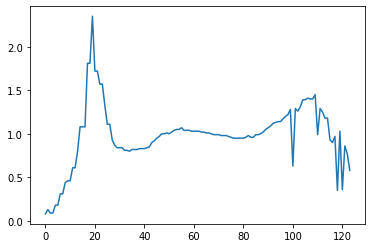

In [9]:
import matplotlib.pyplot as plt

plt.plot([x['LF/HF ratio'] for x in HRV.features])

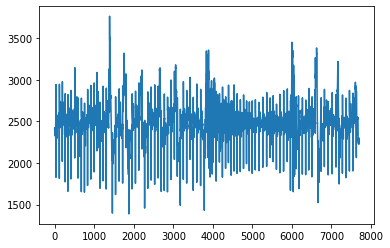

In [10]:
plt.plot(ecg_data)

## Launch on 2 devices

In [16]:
from pythonosc import dispatcher, osc_server
from pythonosc.udp_client import SimpleUDPClient
import biofeatures
import time

# Use actuator IP
# Local Processing IP 192.168.0.100 or localhost 127.0.0.1, Arduino IP
actuator_ip = '127.0.0.1'
actuator_port = 32000
osc_client = SimpleUDPClient(actuator_ip, actuator_port) 


In [18]:
val = 0.0
osc_client.send_message("/actuator/1/inflate", val)
osc_client.send_message("/actuator/2/inflate", val)


In [17]:
val = 100.0
osc_client.send_message("/actuator/1/inflate", val)
osc_client.send_message("/actuator/2/inflate", val)


In [ ]:
deflate("1", 1)

In [ ]:
warmup_inflate("1", 3)

In [ ]:
warmup_inflate("2", 3)

In [ ]:
act_seq.actuation_flag = True

pulsating("1", True)

In [ ]:
act_seq.actuation_flag = False

In [ ]:
osc_client.send_message("/actuator/1/inflate", 0.0)

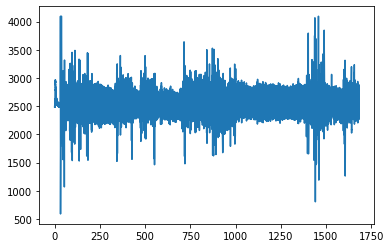

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.linspace(0,len(resp_data)/200., len(resp_data) ), resp_data)

In [2]:
resp_data = np.loadtxt("resp2504.csv", delimiter=',')

In [21]:
save_ecg = np.array(ecg_data)

In [22]:
np.savetxt("ecg2605.csv", save_ecg, delimiter=',')

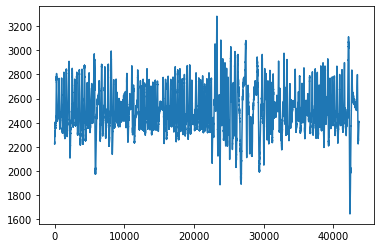

In [15]:
import matplotlib.pyplot as plt
plt.plot(resp_data)

In [25]:
import biosppy.signals.resp as resp
import biosignalsnotebooks as bsnb

processed_data = resp.resp(signal=resp_data, sampling_rate=srate, show=False)

In [15]:
filtered_signal = processed_data[1]

In [16]:
signal_diff = np.diff(filtered_signal)
signal_signum = signal_diff > 0

resp_changes = np.append(np.where(signal_signum[:-1] != signal_signum[1:])[0], [len(signal_signum) - 1])

In [17]:
resp_intervals = np.append([0], resp_changes)
interval_lengths = np.diff(resp_intervals)
is_inhalation = [signal_signum[i] for i in resp_changes]

In [18]:
inhales = []
exhales = []

for i in range(len(interval_lengths)):
    if is_inhalation[i]:
        inhales.append(interval_lengths[i])
    else:
        exhales.append(interval_lengths[i])

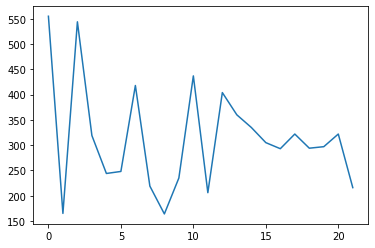

In [19]:
plt.plot(inhales)

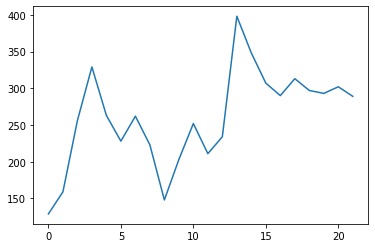

In [20]:
plt.plot(exhales)

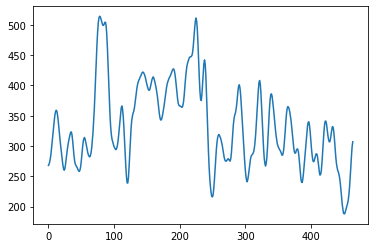

In [51]:
from scipy.ndimage.filters import gaussian_filter1d

ysmoothed = gaussian_filter1d(inhales, sigma=3)
plt.plot(range(465), ysmoothed)
plt.show()


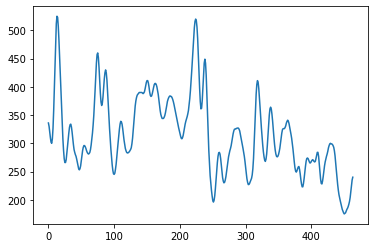

In [52]:
exsmoothed = gaussian_filter1d(exhales, sigma=3)
plt.plot(range(464), exsmoothed)
plt.show()

In [11]:
"alternate_breaths_min13"[-3:]

'n13'

In [2]:
np.mean([1,2,3,4,5])

3.0

In [11]:
HRV.features

[{'nni_mean': 376.67,
  'hr_mean': 165.76,
  'hr_std': 40.78,
  'rmssd': 73.2,
  'lf': 68.52,
  'hf': 812.26,
  'LF/HF ratio': 0.08},
 {'nni_mean': 375.0,
  'hr_mean': 166.19,
  'hr_std': 39.68,
  'rmssd': 74.94,
  'lf': 100.96,
  'hf': 757.12,
  'LF/HF ratio': 0.13},
 {'nni_mean': 376.0,
  'hr_mean': 165.48,
  'hr_std': 38.75,
  'rmssd': 73.84,
  'lf': 58.47,
  'hf': 617.67,
  'LF/HF ratio': 0.09},
 {'nni_mean': 376.0,
  'hr_mean': 165.48,
  'hr_std': 38.75,
  'rmssd': 73.84,
  'lf': 58.47,
  'hf': 617.67,
  'LF/HF ratio': 0.09},
 {'nni_mean': 378.57,
  'hr_mean': 164.24,
  'hr_std': 38.19,
  'rmssd': 72.4,
  'lf': 93.07,
  'hf': 515.59,
  'LF/HF ratio': 0.18},
 {'nni_mean': 378.57,
  'hr_mean': 164.24,
  'hr_std': 38.19,
  'rmssd': 72.4,
  'lf': 93.07,
  'hf': 515.59,
  'LF/HF ratio': 0.18},
 {'nni_mean': 383.86,
  'hr_mean': 162.28,
  'hr_std': 38.38,
  'rmssd': 72.06,
  'lf': 127.27,
  'hf': 408.6,
  'LF/HF ratio': 0.31},
 {'nni_mean': 383.86,
  'hr_mean': 162.28,
  'hr_std': 38.38

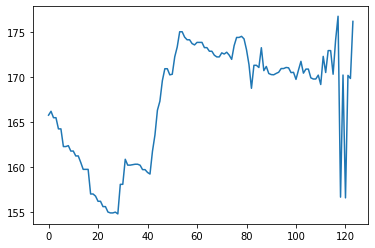

In [12]:
plt.plot([f["hr_mean"] for f in HRV.features])

In [13]:
HRV.r_intervals

array([405, 220, 230, 440, 370, 370, 385, 430, 410, 395, 220, 245, 205,
       280, 215, 255, 440, 345, 220, 260, 225, 425, 380, 400, 365, 315,
       385, 385, 405, 415, 375, 345, 365, 400, 450, 215, 280, 495, 545,
       270, 415, 440, 470, 460, 410, 385, 335, 340, 420, 440, 390, 385,
       605, 550, 430, 490, 205, 300, 480, 385, 220, 210, 425, 455, 455,
       425])

In [9]:
resp_data

[2468.0,
 2469.0,
 2460.0,
 2453.0,
 2451.0,
 2448.0,
 2441.0,
 2439.0,
 2434.0,
 2428.0,
 2426.0,
 2420.0,
 2419.0,
 2418.0,
 2413.0,
 2408.0,
 2411.0,
 2404.0,
 2405.0,
 2401.0,
 2399.0,
 2394.0,
 2392.0,
 2394.0,
 2392.0,
 2385.0,
 2389.0,
 2398.0,
 2386.0,
 2385.0,
 2382.0,
 2379.0,
 2384.0,
 2386.0,
 2380.0,
 2377.0,
 2378.0,
 2375.0,
 2374.0,
 2372.0,
 2375.0,
 2376.0,
 2376.0,
 2375.0,
 2373.0,
 2374.0,
 2373.0,
 2372.0,
 2369.0,
 2371.0,
 2367.0,
 2371.0,
 2368.0,
 2371.0,
 2373.0,
 2380.0,
 2371.0,
 2370.0,
 2372.0,
 2383.0,
 2370.0,
 2376.0,
 2370.0,
 2376.0,
 2375.0,
 2378.0,
 2374.0,
 2374.0,
 2378.0,
 2381.0,
 2379.0,
 2379.0,
 2373.0,
 2379.0,
 2383.0,
 2382.0,
 2382.0,
 2381.0,
 2383.0,
 2384.0,
 2379.0,
 2384.0,
 2409.0,
 2387.0,
 2390.0,
 2387.0,
 2383.0,
 2391.0,
 2389.0,
 2383.0,
 2392.0,
 2391.0,
 2394.0,
 2389.0,
 2394.0,
 2393.0,
 2397.0,
 2396.0,
 2393.0,
 2396.0,
 2389.0,
 2396.0,
 2393.0,
 2395.0,
 2399.0,
 2399.0,
 2399.0,
 2397.0,
 2403.0,
 2402.0,
 2435.0,
 